In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
keras = tf.keras

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
data_size = 1000
batch_time = 20
niters = 3000
batch_size = 20

true_y0 = tf.to_float([[2., 0.]])
t = tf.to_float(np.linspace(0., 25., data_size))
true_A = tf.to_float([[-0.1, 2.0], [-2.0, -0.1]])

In [6]:
class Lambda(tf.keras.Model):
    def call(self, inputs, **kwargs):        
        return tf.matmul(inputs**3, true_A)

    def compute_output_shape(self, input_shape):        
        return input_shape

In [7]:
from neural_ode import NeuralODE

In [8]:
neural_ode = NeuralODE(Lambda(), tmax=25.0, num_steps=data_size)
yN, states_history = neural_ode.forward(true_y0, return_states="numpy")

true_y = np.concatenate(states_history)
true_y.shape

(1001, 2)

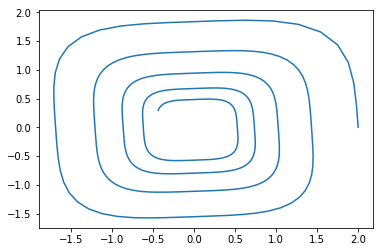

In [9]:
x, y = np.concatenate(states_history).T
plt.plot(x, y)

In [10]:
def get_batch():
    starts = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2)
    batch_yN = true_y[starts + batch_time]
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

In [11]:
class ODEModel(tf.keras.Model):

    def __init__(self):
        super(ODEModel, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(2)        

    def call(self, inputs, **kwargs):
        h = inputs**3
        h = self.linear1(h)
        h = self.linear2(h)
        return h

    def compute_output_shape(self, input_shape):
        return input_shape

In [12]:
model = ODEModel()
neural_ode = NeuralODE(model, tmax=1.0, num_steps=batch_time)
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-4)

In [13]:
def compute_gradients_and_update(batch_y0, batch_yN):
    pred_y = neural_ode.forward(batch_y0)
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_mean(tf.abs(pred_y - batch_yN))
        
    dLoss = g.gradient(loss, pred_y)
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)
    optimizer.apply_gradients(zip(dWeights, model.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/3000 [00:00<?, ?it/s]

step= 0


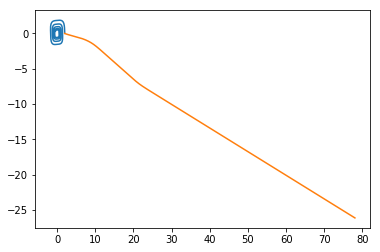

 16%|█▌        | 486/3000 [00:06<00:33, 74.61it/s]

step= 500


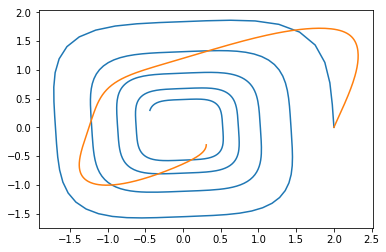

 33%|███▎      | 984/3000 [00:10<00:20, 96.92it/s]

step= 1000


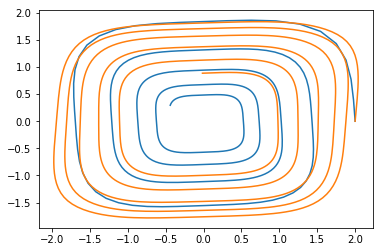

 50%|████▉     | 1498/3000 [00:13<00:13, 108.50it/s]

step= 1500


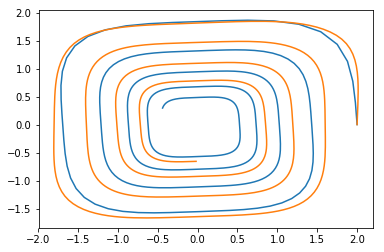

 66%|██████▋   | 1991/3000 [00:17<00:08, 114.87it/s]

step= 2000


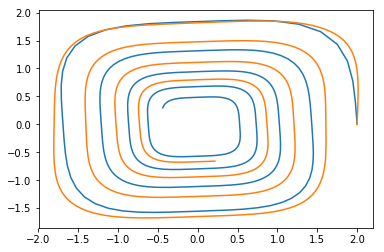

 83%|████████▎ | 2499/3000 [00:20<00:04, 119.55it/s]

step= 2500


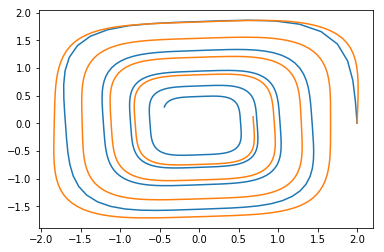

100%|██████████| 3000/3000 [00:24<00:00, 122.56it/s]


In [14]:
loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:
        print("step=", step)
        neural_ode_test = NeuralODE(model, tmax=25.0, num_steps=data_size)
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
        plt.plot(*np.concatenate(states_history).T)
        plt.plot(*np.concatenate(states_history_model).T)
        plt.show()    

In [18]:
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())

100%|██████████| 3000/3000 [00:15<00:00, 198.95it/s]


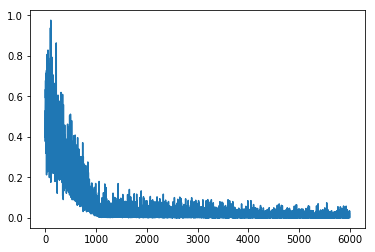

In [19]:
plt.plot(loss_history)

In [20]:
neural_ode_test = NeuralODE(model, tmax=500.0, num_steps=3 * data_size)
yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")

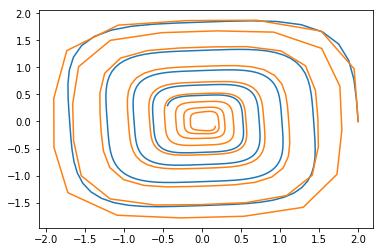

In [21]:
plt.plot(*np.concatenate(states_history).T)
plt.plot(*np.concatenate(states_history_model).T)

In [22]:
model = ODEModel()
neural_ode = NeuralODE(model, tmax=1.0, num_steps=batch_time)
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-4)

In [23]:
def compute_gradients_and_update(batch_y0, batch_yN):
    with tf.GradientTape() as g:
        pred_y = neural_ode.forward(batch_y0)
        loss = tf.reduce_mean(tf.abs(pred_y - batch_yN))    
    gradients = g.gradient(loss, model.weights)  
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/3000 [00:00<?, ?it/s]

step= 0


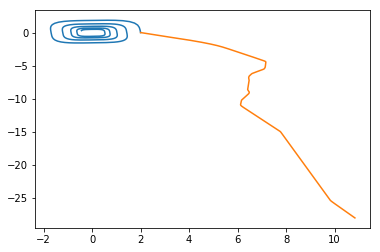

 16%|█▋        | 492/3000 [00:05<00:26, 94.52it/s]

step= 500


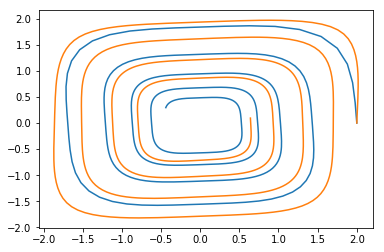

 33%|███▎      | 993/3000 [00:07<00:16, 124.48it/s]

step= 1000


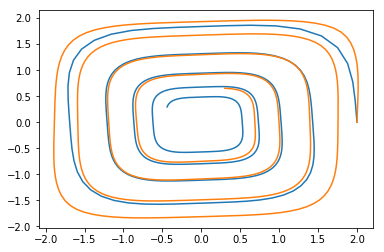

 50%|████▉     | 1498/3000 [00:10<00:10, 138.44it/s]

step= 1500


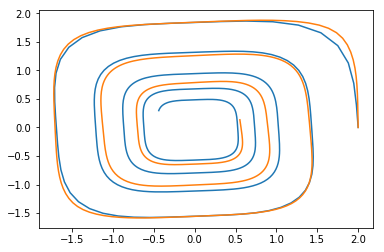

 66%|██████▌   | 1977/3000 [00:13<00:06, 146.34it/s]

step= 2000


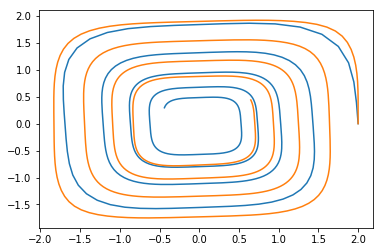

 83%|████████▎ | 2496/3000 [00:16<00:03, 150.65it/s]

step= 2500


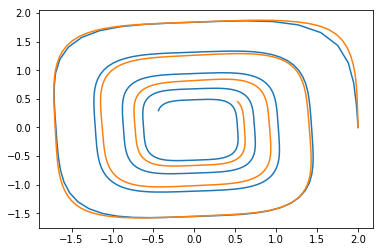

100%|██████████| 3000/3000 [00:19<00:00, 155.60it/s]


In [24]:
loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:
        print("step=", step)
        neural_ode_test = NeuralODE(model, tmax=25.0, num_steps=data_size)
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
        plt.plot(*np.concatenate(states_history).T)
        plt.plot(*np.concatenate(states_history_model).T)
        plt.show()

In [25]:
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())

100%|██████████| 3000/3000 [00:10<00:00, 284.86it/s]


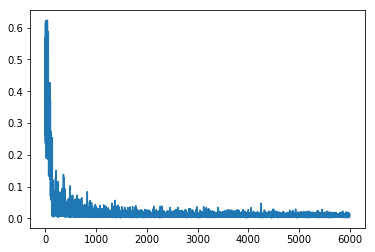

In [26]:
plt.plot(loss_history)

In [27]:
neural_ode_test = NeuralODE(model, tmax=500.0, num_steps=5 * data_size)
yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")

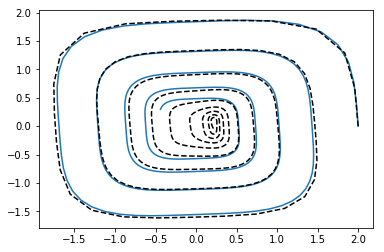

In [28]:
plt.plot(*np.concatenate(states_history).T)
plt.plot(*np.concatenate(states_history_model).T, "k--")

In [29]:
neural_ode_test = NeuralODE(model, tmax=-25.0, num_steps=3 * data_size)
yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")

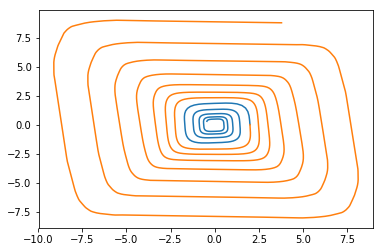

In [30]:
plt.plot(*np.concatenate(states_history).T)
plt.plot(*np.concatenate(states_history_model).T)

In [31]:
def get_path_batch():
    starts = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2)
    batch_yN = [true_y[starts + i] for i in range(batch_time+1)]
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

In [32]:
model = ODEModel()
neural_ode = NeuralODE(model, tmax=1.0, num_steps=batch_time)

In [33]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-4)

In [34]:
def compute_gradients_and_update(batch_y0, batch_yN):
    with tf.GradientTape() as g:
        pred_y = neural_ode.forward(batch_y0, return_states="tf")
        pred_path = tf.stack(pred_y[1])
        loss = tf.reduce_mean(tf.abs(pred_path - batch_yN))    
    gradients = g.gradient(loss, model.weights)  
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/3000 [00:00<?, ?it/s]

step= 0


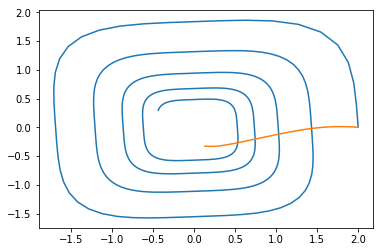

 16%|█▌        | 479/3000 [00:05<00:29, 84.53it/s]

step= 500


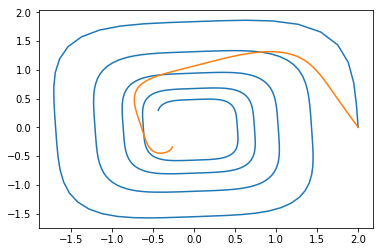

 33%|███▎      | 977/3000 [00:09<00:18, 108.21it/s]

step= 1000


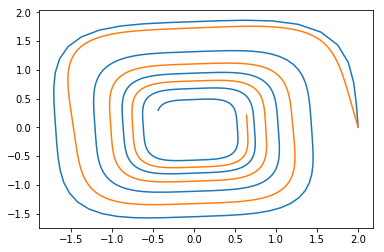

 50%|████▉     | 1499/3000 [00:12<00:12, 120.30it/s]

step= 1500


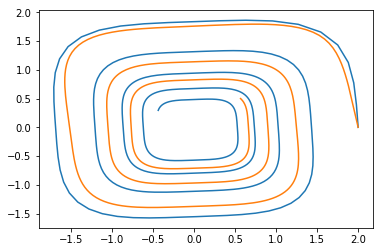

 66%|██████▌   | 1981/3000 [00:15<00:08, 125.13it/s]

step= 2000


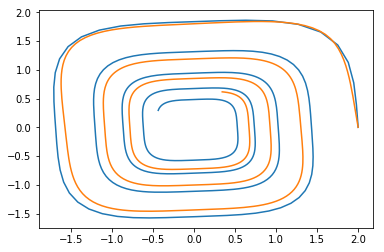

 83%|████████▎ | 2488/3000 [00:19<00:03, 128.61it/s]

step= 2500


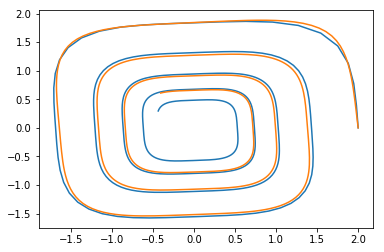

100%|██████████| 3000/3000 [00:22<00:00, 131.78it/s]


In [35]:
loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_path_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:
        print("step=", step)
        neural_ode_test = NeuralODE(model, tmax=25.0, num_steps=data_size)
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
        plt.plot(*np.concatenate(states_history).T)
        plt.plot(*np.concatenate(states_history_model).T)
        plt.show()

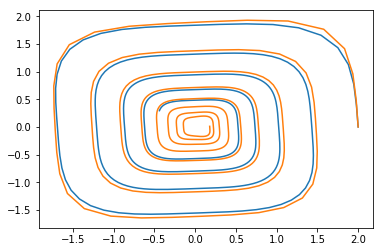

In [36]:
neural_ode_test = NeuralODE(model, tmax=500.0, num_steps=5 * data_size)
yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
plt.plot(*np.concatenate(states_history).T)
plt.plot(*np.concatenate(states_history_model).T)